## Comparing basin mean irradiances
#### Given geodatabase (ArcGIS file) from Brian
File here:

/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap/BasinShapefiles/SierraBasins.shp

# NOTE:
This script only works in python 2.7. Python 3.5 breaks the basemap shapefile reading routine.

In [72]:
# Compare basin mean irradiance between products for the Kern, Tuolumne, American basins
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
from netCDF4 import num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pickle
import pandas as pd
import xarray as xray
import scipy
import shapely

# OS interaction
import sys
import os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'
dir_shape = '/BasinShapefiles'

In [2]:
###############
## Functions ##
###############

### shapely function: returns points contained within a polygon
def contained_points(apolygon, basin_points):
    points_in_basin = filter(prep(apolygon).contains, basin_points)
    # Found points within the polygon, output lat,lon
    if points_in_basin:
        x = []
        y = []
        for p in points_in_basin:
            x.append(p.x)
            y.append(p.y)
        x = np.array(x)
        y = np.array(y)
        return (x,y)
    # No point within the polygon, output lat,lon of nearest point
    else:
        dist = []
        for mp in mapped_points:
            dist.append(df_map['poly'][0].distance(mp))
        dist = np.array(dist)
        ind = np.squeeze(np.nonzero(dist==dist.min()))
        return(np.atleast_1d(mapped_points[ind].x),\
               np.atleast_1d(mapped_points[ind].y))

In [3]:
##### Basemap
def build_basemap(lon,lat):
    # Lat/Lon handling - map extent
    bmap_dict = {}
    bmap_dict['lat_i'] = np.min(lat)
    bmap_dict['lon_i'] = np.min(lon)
    bmap_dict['lat_j'] = np.max(lat)
    bmap_dict['lon_j'] = np.max(lon)
    
    bmap_dict['lat_mid'] = lat[np.round(lat.size/2)]
    bmap_dict['lon_mid'] = lon[np.round(lon.size/2)]
    
    bmap_dict['lat_labels'] = np.arange(np.round(bmap_dict['lat_i']), np.round(bmap_dict['lat_j']), 2)
    bmap_dict['lon_labels'] = np.arange(np.round(bmap_dict['lon_i']), np.round(bmap_dict['lon_j']), 2)
    
    bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                    urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                    rsphere=(6378137.00,6356752.3142),resolution='l',projection='cyl',\
                    lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
    
    return bmap,bmap_dict

In [4]:
####################################
## Read previously processed data ##
####################################

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.SYN.irrad.monthly.nc')

############
## MTCLIM ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')

#########################
## Ground Observations ##
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.monthly.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

## List w/ all irradiance datasets
monthly_mean = {}
monthly_mean['syn'] = syn
monthly_mean['nldas'] = nldas
monthly_mean['mtclim'] = mtclim
monthly_mean['wrf'] = wrf
# monthly_mean['modis'] = modis
monthly_mean['grobs'] = grobs

pr_names = ['mtclim','nldas','syn','wrf']

In [5]:
#####################
## Basin Shapefile ##
#####################
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

##### Basemap
lat = mtclim.latitude.values
lon = mtclim.longitude.values
bmp,bmd = build_basemap(lon,lat)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']

## Shape files
os.chdir(dir_bmap+dir_shape)
_out = bmp.readshapefile('./SierraBasins', 'SierraBasins', drawbounds=False, color='none') 

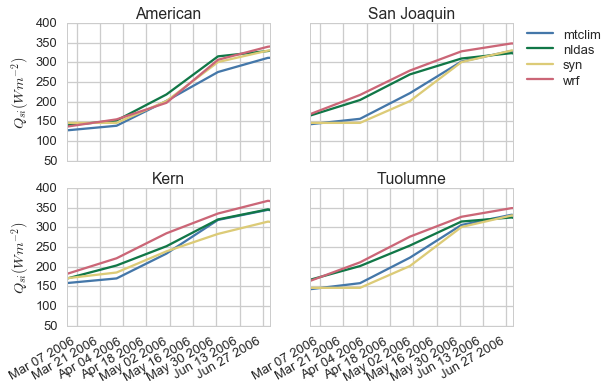

In [6]:
##########################
## Mean Qsi over basins ##
##########################

colsche = np.array([[68.,119.,170.],
                    [17.,119.,71.],
                    [221.,204.,119.],
                    [204.,102.,119.]]) / 256.
# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})
   
## Points within basin
fig,axes = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,6))
axes = axes.flatten()
for k, (bname, basins) in enumerate(zip(df_map['name'], df_map['poly'])):
    ax = axes[k]
    for n, pr in enumerate(pr_names):
        
        ## Product grid lat/lon -> shapely 'point' class (find points in basin and average)
        mlon, mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)

        ax.plot(monthly_mean[pr].time,\
                 monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points'),\
                color=colsche[n],label=pr)
    
    ## Format graphs
    if k == 1:
        ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(1, .5, .5, .5))    
    ax.set_title(bname)
    ax.set_xlim(datetime(2006,3,1),datetime(2006,7,1))
    if k == 0 or k == 2:
        ax.set_ylabel('$Q_{si} (Wm^{-2})$')
    
    fig.autofmt_xdate()

American (nldas): 22.4340042295
American (syn): 19.3014411237
American (wrf): 20.4899165032
San Joaquin (nldas): 14.1083389633
San Joaquin (syn): 7.9693859538
San Joaquin (wrf): 31.6116443547
Kern (nldas): 6.60056544704
Kern (syn): -0.736073206617
Kern (wrf): 21.6752989208
Tuolumne (nldas): 12.8692785257
Tuolumne (syn): 5.20000688055
Tuolumne (wrf): 26.6556230783


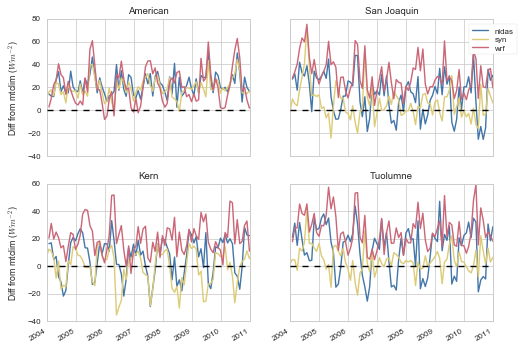

In [76]:
#####################################
## Mean Qsi difference from MTCLIM ##
#####################################
# Color
colsche = np.array([[68., 119., 170.],
                    [221., 204., 119],
                    [204., 102., 119.]]) / 256.

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})
   
## Points within basin
fig,axes = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,6))
axes = axes.flatten()
pr_names = ['nldas','syn','wrf']
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
    ax = axes[k]
    
    ## Product grid lat/lon -> shapely 'point' class (MTCLIM)
    pr = 'mtclim'
    mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
    mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
    cont_p = contained_points(basins,mapped_points)
    mc = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')
    
    ## Product grid lat/lon -> shapely 'point' class (Difference from MTCLIM)
    for n,pr in enumerate(pr_names):
        # Product grid lat/lon -> shapely 'point' class
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)
        basin_diff = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')-mc
        ax.plot(basin_diff.time,basin_diff,\
                color=colsche[n],label=pr)
        print(bname + ' (' + pr + '): ' + str(basin_diff.mean(dim='time').values))
    
    ## Format graphs
    if k == 1:
        ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(.75, .6, .5, .5),frameon=True)    
    ax.set_title(bname)
    ax.set_xlim(datetime(2004,1,1),datetime(2011,1,1))
    if k == 0 or k == 2:
        ax.set_ylabel('Diff from mtclim ($Wm^{-2}$)')
    ax.plot(np.array((datetime(2004,1,1), datetime(2011,1,1))),
            np.array((0,0)), 'k--', zorder=4)
    
fig.autofmt_xdate()
os.chdir(dir_print)
# fig.savefig('BasinComparison.MTCLIMDiff.pdf')

American (nldas): 22.4340042295
American (syn): 19.3014411237
American (wrf): 20.4899165032
Kern (nldas): 6.60056544704
Kern (syn): -0.736073206617
Kern (wrf): 21.6752989208
Tuolumne (nldas): 12.8692785257
Tuolumne (syn): 5.20000688055
Tuolumne (wrf): 26.6556230783


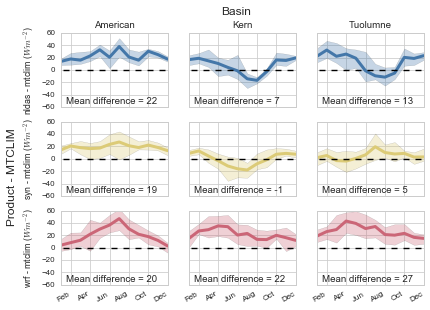

In [103]:
## Mean Qsi difference from MTCLIM
#####################################
# Color scheme
colsche = np.array([[68., 119., 170.],
                    [221., 204., 119],
                    [204., 102., 119.]]) / 256.
monthTimes = np.arange(1,13)
monthLabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})
# Drop the San Joaquin
df_map = df_map.drop(1)

## Points within basin
fig,axes = plt.subplots(3,3,sharex='col',sharey='row',figsize=(6.5,5))
pr_names = ['nldas','syn','wrf']
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
        
    ## Product grid lat/lon -> shapely 'point' class (MTCLIM)
    pr = 'mtclim'
    mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
    mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
    cont_p = contained_points(basins,mapped_points)
    mc = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')
    
    ## Product grid lat/lon -> shapely 'point' class (Difference from MTCLIM)
    for n, pr in enumerate(pr_names):
        ax = axes[n, k]
        # Product grid lat/lon -> shapely 'point' class
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)
        # Difference in Qsi at the basin level
        basin_diff = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')-mc
        
        # Fill between min and max value
        ax.fill_between(np.arange(1, 13),
                        basin_diff.groupby('time.month').max(dim='time'),
                        basin_diff.groupby('time.month').min(dim='time'),
                        alpha=0.3, facecolor=colsche[n])
        # Plot mean difference
        ax.plot(np.arange(1, 13), basin_diff.groupby('time.month').mean(dim='time'), color=colsche[n], linewidth=3)
        print(bname + ' (' + pr + '): ' + str(basin_diff.mean(dim='time').values))
        
        # Zero lines
        ax.plot(np.array((0, 12)),
                np.array((0, 0)),
                'k--', zorder=4)

        ## Format graphs
        ax.set_xlim(1, 12)
        ax.set_ylim(-60, 60)
        ax.text(1.5, -55, "Mean difference = " + "%.0f" % round(basin_diff.mean(dim='time').values))
        if n == 0:
            ax.set_title(bname)
        if k == 0:
            ax.set_ylabel(pr + ' - mtclim ($Wm^{-2}$)')
        if n == 2:
            ax.set_xticks(monthTimes[1:13:2])
            ax.set_xticklabels(monthLabels[1:13:2])
            

fig.text(0.5, 0.95, 'Basin', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Product - MTCLIM', va='center', rotation='vertical', fontsize=12)

fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('BasinComparison.MonthlyComposite.MTCLIMDiff.pdf')
fig.savefig('BasinComparison.MonthlyComposite.MTCLIMDiff.png')
fig.savefig('BasinComparison.MonthlyComposite.MTCLIMDiff.eps')

In [ ]:
##########################
## Mean Qli over basins ##
##########################
colsche = kgraph.SRON(4)
pr_names = ['mtclim','nldas','syn','wrf']

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})

## Points within basin
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
    fig,ax = plt.subplots(1,1,figsize=(6,3))
    for n,pr in enumerate(pr_names):
        ## Product grid lat/lon -> shapely 'point' class, mean of Qli within basin
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)

        ax.plot(monthly_mean[pr].time,\
                 monthly_mean[pr].LWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points'),\
                color=colsche[n],label=pr)
    ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(1, .5, .5, .5))    
    ax.set_title(bname)
    ax.set_xlim(datetime(2006,3,1),datetime(2006,7,1))
    ax.set_ylabel('$Q_{li} (Wm^{-2})$')
    ax.set_ylim(180,340)
    
    fig.autofmt_xdate()

In [ ]:
import solargeo

## Cloudiness expression
def CloudIndex(Qsi,EL):
    ## Clearness index
    k = Qsi/(1365*np.sin(EL*np.pi/180))
    
    ## Cloudiness index
    c = np.empty_like(k)

    # Interpolate for broken cloud conditions
    LL = .4 # Overcast
    UL = .7 # Clear
    c = 1 - (k-LL)/(UL-LL)
    
    # Upper and lower limits
    c = np.where(c < LL, 1, c) 
    c = np.where(c > UL, 0, c)

## How much does $ET_0$ vary between each $Q_{si}$ dataset? 

In [ ]:
##################################
## Reference Evapotranspiration ##
##################################
def ETref(Qsi,Qli,T_surf=np.arange(0,40,.5),T_air = np.arange(5,45,.5),U=2,RH=.5):
    ## Citation: Irmak, S., I. Kabenge, K. E. Skaggs, and D. Mutiibwa (2012), 
    #            Trend and magnitude of changes in climate variables and reference 
    #            evapotranspiration over 116-yr period in the Platte River Basin, c
    #            entral Nebraska-USA, 
    #            J. Hydrol., 420-421, 228–244, doi:10.1016/j.jhydrol.2011.12.006.
    ## Meteorological variables defined in function call
    #     T_air - units?
    #     VPD - kPA
    #     U - m/s
    #     G - ground heat capacity, assumed zero at daily scale
        
    ## Constants
    # slope of saturation vapor pressure versus air temperature curve (kPa C^1)
    DELTA = 4098 * ( .6108 * np.exp( (17.27*T_air) / (T_air+237.3)) ) / (T_air+237.3)**2
    # Psychrometric constant
    GAMMA = 101.325*.001012/(2.26*.622) #kPa * MJ*kg^-1*K^-1 / (MJ*kg^-1) = kPa * K^-1
    Cn = 900
    Cd = .34
    sigma = 5.67*10**-8
    
    ## Radiation: Convert Qsi: Wm^-2  -> MJ/(m^2*day)
    # Shortwave in
    Qsi = Qsi * (60*60*24) / (10**6)
    # Albedo
    alpha = .23
    # Longwave radiation in
    Qli = Qli * (60*60*24) / (10**6)
    # Longwave radiation out
    Qlo = -(T_surf**4)*sigma * (60*60*24) / (10**6)
    # NET
    Qn = (1-alpha)*Qsi + Qlo + Qli
    
    ## VPD
    e_sat = WaterVaporPress(T_air)/100
    e_act = e_sat * RH
    VPD = e_sat-e_act
    
    ## ETref
    ETref = ( .408*DELTA*Qn + (GAMMA*Cn/(T_air+273)) * U*VPD ) / ( DELTA + GAMMA*(1+Cd*U) )
    return ETref

def WaterVaporPress(temperature):
    ## Returns the saturation vapor pressure (hPa) for a given temperature
    # temperature must be in K not C
    if np.max(temperature) < 200:
        temperature = temperature + 273.15
    
    ea = 6.1078 * np.exp(17.269388 * (temperature - 273.16) / (temperature - 35.86) )
    return ea

In [ ]:
## Points within basin
# for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
bname = df_map['name'][3]
basins = df_map['poly'][3]

## Date
d = pd.date_range(start='2006-03-01',freq='M',periods=1)

## Points within basin
fig,axes = plt.subplots(1,1,sharex='col',sharey='row',figsize=(6,6))
# axes = axes.flatten()

## Longwave from MTCLIM over basin
pr = 'mtclim'
mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
cont_p = contained_points(basins,mapped_points)
Qli = mtclim.LWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points').loc[{'time':d}]

## Shortwave over basin for each product
for n,pr in enumerate(pr_names):
    ## Product grid lat/lon -> shapely 'point' class, mean of Qli within basin
    mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
    mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]

    # lat (index 1) /lon (index 0) of points within basin
    cont_p = contained_points(basins,mapped_points)

    # Downwelling shortwave
    Qsi = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points').loc[{'time':d}]
    print(pr)
    print(Qsi.values)

    ## Default values
    ET0_def = ETref(Qsi.values,Qli.values)
    axes.plot(np.arange(0,40,.5),ET0_def,label=pr,color=colsche[n])
    axes.set_title('"Default" values')
    axes.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(1, .5, .5, .5))
    
# fig.savefig('PET.Mountain')
    
#     ## Changing RH ##
#     # RH = 30%
#     ET0 = ETref(Qsi.values,Qli.values,RH=.3)
#     axes[1].plot(np.arange(0,40,.5),ET0,':',label='RH=30%',color=colsche[n])
#     # RH = 80%
#     ET0 = ETref(Qsi.values,Qli.values,RH=.8)
#     axes[1].plot(np.arange(0,40,.5),ET0,'--',label='RH=80%',color=colsche[n])
#     axes[1].set_title('Altering RH')
#     axes[1].plot(np.arange(0,40,.5),ET0_def,label=pr,color=colsche[n])

#     ## Changing Tair-Tsurf
#     # Delta-T = +10
#     T_surf = np.arange(0,40,2)
#     T_air = T_surf+10
#     ET0 = ETref(Qsi.values,Qli.values,T_surf=T_surf,T_air=T_air)
#     axes[2].plot(T_surf,ET0,'-o',label=pr,color=colsche[n])
#     # Delta-T = -10; unphysical
#     T_surf = np.arange(0.1,40.1,2)
#     T_air = T_surf-10
#     ET0 = ETref(Qsi.values,Qli.values,T_surf=T_surf,T_air=T_air)
#     axes[2].plot(T_surf,ET0,'-v',label=pr,color=colsche[n])
#     axes[2].set_title('Altering $T_{air} - T_{surf}$')
#     axes[2].plot(np.arange(0,40,.5),ET0_def,label=pr,color=colsche[n])

In [ ]:
## Points within basin
# for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
bname = df_map['name'][3]
basins = df_map['poly'][3]

## Date
d = pd.date_range(start='2006-03-01',freq='M',periods=1)

## Points within basin
fig,ax = plt.subplots(1,1,figsize=(6,3))

## Longwave from MTCLIM over basin
pr = 'mtclim'
mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
cont_p = contained_points(basins,mapped_points)
Qli = mtclim.LWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points').loc[{'time':d}]

## Shortwave over basin for each product
for n,pr in enumerate(pr_names):
    ## Product grid lat/lon -> shapely 'point' class, mean of Qli within basin
    mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
    mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]

    # lat (index 1) /lon (index 0) of points within basin
    cont_p = contained_points(basins,mapped_points)

    # Downwelling shortwave
    Qsi = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points').loc[{'time':d}]

    # Default values
    T_surf = np.arange(5,20,.5)
    T_air = T_surf+5
    ET0 = ETref(Qsi.values,Qli.values,T_surf=T_surf,T_air=T_air)
    ax.plot(T_air,ET0,label=pr,color=colsche[n])
    
    ax.legend(loc='lower center',labelspacing=.25,markerscale=1,bbox_to_anchor=(.6, .2, .5, .5),frameon=True)    
    ax.set_title(bname)
    ax.set_ylabel('ET (mm day$^{-1}$)')
    ax.set_xlabel('$T_{air} (C^{\circ})$')
    ax.set_xlim(T_air.min(),T_air.max())

## Does VPD change when $\Delta T$ is constant but $T_{surf}$ and $T_{air}$ are not?
ANSWER: _yes_

BUT! The is $(e_{sat} - e_{actual})$ which only depends on $T_{air}$. So the below point is moot for this study.

In [ ]:
def WaterVaporPress(temperature):
    ## Returns the saturation vapor pressure (hPa) for a given temperature
    # temperature must be in K not C
    if np.max(temperature) < 200:
        temperature = temperature + 273.15
    
    ea = 6.1078 * np.exp(17.269388 * (temperature - 273.16) / (temperature - 35.86) )
    return ea

Tair = np.arange(0,40,.5)
Tsurf = np.arange(5,45,.5)

VPD = np.empty_like(Tsurf)
for n,ta in enumerate(Tair):
    VPD[n] = WaterVaporPress(Tair[n]) - WaterVaporPress(Tsurf[n])
    
print(VPD.shape)
plt.plot(Tair,VPD)
plt.axes().set_xlabel('Tair (C)')
plt.axes().set_ylabel('VPD (hPA)')